<a href="https://colab.research.google.com/github/SeanSDarcy2001/CISProgrammingAssignments/blob/main/CIS1HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Computer Integrated Surgery 1: Programming Assignment 1

## PART 1
## use package to represent 3D points
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

p1    = np.array([-1489., -4913.,  4345.])
p2    = np.array([ 2633., -3268.,  5249.])
pcalc = np.array([-3210., -4390.,  3930.])

def normit(v):
    return v / np.sqrt((v**2).sum())

n1, n2, ncalc = [normit(p) for p in [p1, p2, pcalc]]

In [13]:
## use packages to represent 3D rotations
def identity():
  return np.array([[1, 0,  0], [0, 1, 0], [0, 0, 1]])

# generate skew matrix from 1x3 array 
def skew(v) :
  skewArg = normit(v)
  ax = skewArg[0]
  ay = skewArg[1]
  az = skewArg[2]
  skew = np.array([[0, -az,  ay], [az, 0, -ax], [-ay, ax, 0]])
  return skew

# generate 3D Rotation matrix
# @Params: alpha, beta, gamma - Rotation angles about the x, y, and z axes respectively
# @Returns: 3D Rotation matrix
def RotfromAngles(alpha, beta, gamma) :
  Rx = np.array([[1, 0,  0], [0, np.cos(alpha), -np.sin(alpha)], [0, np.sin(alpha), np.cos(alpha)]])
  Ry = np.array([[np.cos(beta), 0,  np.sin(beta)], [0, 1, 0], [-np.sin(beta), 0, np.cos(beta)]])
  Rz = np.array([[np.cos(gamma), -np.sin(gamma),  0], [np.sin(gamma), np.cos(gamma), 0], [0, 0, 1]])
  R = RotfromComponents(Rx, Ry, Rz)
  return R

def smallAngleR(v, theta) :
  n = normit(v)
  return (identity() + skew(theta * n))

def RotfromComponents(Rx, Ry, Rz) :
  R = np.dot(np.dot(Rx, Ry), Rz)
  return R

# convert 3D vector into 4D homogeneous coords
def homogenousVector(v, scale) :
  Vx = scale * v[0]
  Vy = scale * v[1]
  Vz = scale * v[2]
  V = np.array([Vx, Vy, Vz, scale])

R = RotfromAngles(0, 1, 0)
print(R)

# theta = int
# RxTheta = np.array([1, 0,  0], [0, np.cos(theta), -np.sin(theta)], [0, np.sin(theta), np.cos(theta)]))
# RyTheta

[[ 0.54030231  0.          0.84147098]
 [ 0.          1.          0.        ]
 [-0.84147098  0.          0.54030231]]


[[ 0.54030231  0.          0.84147098  5.        ]
 [ 0.          1.          0.          7.        ]
 [-0.84147098  0.          0.54030231  9.        ]
 [ 0.          0.          0.          1.        ]]


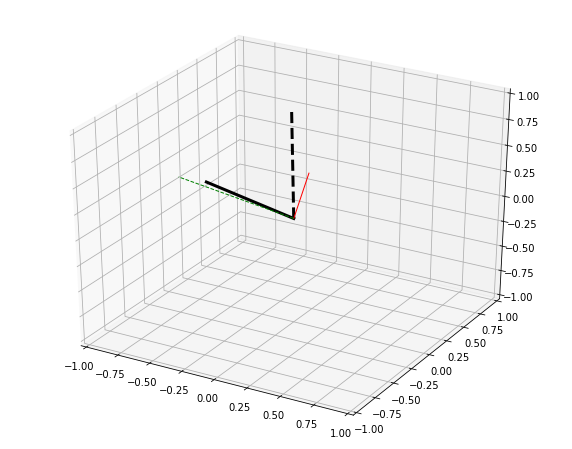

In [21]:
## use packages to represent 3D frame transformations

# define Frame using Rotation and Translation
# @Params: Rotation R and Translation p
# @Return: Frame
def getFrame(R, p):
  F = np.row_stack((np.column_stack((R, p)),
                    [0,0,0,1]))
  return F

# test case
p = np.array([5, 7, 9])
F = getFrame(R, p)
print(F)

# applies frame transformation to vector
# @Params: Frame F and Vector v
# @Return: transformed vector
def appFrame(F, v):
  return np.dot(F, v)

## example?
new_zaxis  = normit(np.cross(n1, n2))
new_xaxis  = n1
zero       = np.zeros(3) 

fig = plt.figure(figsize=[10, 8])
ax  = fig.add_subplot(1, 1, 1, projection='3d')

x, y, z = zip(zero, new_xaxis)
plt.plot(x, y, z, '-k', linewidth=3)

x, y, z = zip(zero, new_zaxis)
plt.plot(x, y, z, '--k', linewidth=3)

x, y, z = zip(zero, n2)
plt.plot(x, y, z, '-r', linewidth=1)

x, y, z = zip(zero, ncalc)
plt.plot(x, y, z, '--g', linewidth=1)

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

plt.show()

# Contributions

## Seby


*   developed proficiency with a Cartesian math package for 3D points rotations, and frame transformations.


## Alex


*   developed proficiency with a Cartesian math package for 3D points rotations, and frame transformations.
*   List item

